## Bizkaiko etxeak
### Houses of Biscay

[Mikel Iturbe](http://iturbe.info), 2016

[Bizkaiko etxeak](http://bizkaikoetxeak.iturbe.info) (Houses of Biscay) is an interactive map where the buildings of Biscay are depicted. The buildings are colored based on their construction/restoration date. It was inspired by a similar [Dutch map](http://code.waag.org/buildings/).

As the raw map data (in [shapefiles](https://en.wikipedia.org/wiki/Shapefile)) from the cadastre does not have the construction year embedded it is necessary to work a bit in order to get and embed the information we want in the shapefile.

This Jupyter notebook explains the process of getting and transforming the data used to build the shapefiles that will later be used with [Tilemill](https://github.com/tilemill-project/tilemill) to create the map.

#### Tools of the trade

In [1]:
import shapefile
import pandas as pd
import os
import glob
from IPython.display import Image
from tqdm import tqdm

### 1. Get cadastral data

Cadastral data can be downloaded from the [website of the cadastre of Biscay](http://www.bizkaia.eus/home2/Temas/DetalleTema.asp?Tem_Codigo=5181&Idioma=IN) from the [open access data section](http://apps.bizkaia.net/KUPW/servlet/webAgentKUPW). Cadastral data is ordered by municipality and has to be downloaded by hand for all the municipalities in the province (there is a captcha). In this case, I used the urban datasets.

Even if the data is publicly accessible, it is copyrighted and it is property of the Provincial Council of Biscay. Therefore, original and transformed data is not shared along the notebook. Feel free to download the data and play yourselves. Only a small sample is provided for example purposes.

### 2. Understanding the data

When we unzip a downloaded municipality file from the cadastre, we can see that there are many different shapefiles and one CSV file (004 is the code of the municipality):

In [2]:
os.listdir('../data/004/')

['004_KU_Municipios.shx',
 '004_KU_Edificios.shp',
 '004_KU_Poligonos.dbf',
 '004_KU_Poligonos.shx',
 '004_KU_Anota_Calles.shx',
 '004_KU_Num_Portal.shp',
 '004_KU_Parcelas.shx',
 '004_KU_Anota_Calles.dbf',
 '004_KU_Manzanas.shp',
 '004_KU_Parcelas.shp',
 '004_KU_Manzanas.shx',
 '004_KU_Municipios.dbf',
 '004_KU_Parcelas.dbf',
 '004_KU_Manzanas.dbf',
 '004_KU_Edificios.shx',
 '004_KU_Anota_Calles.shp',
 '004_KU_Edificios.dbf',
 '004_KU_Poligonos.shp',
 '004_KU_Num_Portal.dbf',
 '004_KU_Municipios.shp',
 '004_KU_Num_Portal.shx',
 '004.F20161002.CSV']

#### 2.1 CSV files

The CSV file for each municipality is the file that has all the cadastre data recorded. By loading the CSV file into a [Pandas](http://pandas.pydata.org/) dataframe, we can explore and later compute the data more easily.



In [3]:
df_sample = pd.read_csv('../data/004/004.F20161002.CSV', 
                        sep='\s*\";"\s*', 
                        engine='python', 
                        encoding='latin1', 
                        header=1)

In [4]:
len(df_sample.columns)

26

In [5]:
pd.set_option("display.max_columns",26)

# For illustration purposes, we will use the reference of a town hall
df_sample[df_sample.Ref_Catastral=='U4017730Q']

,"""Tipo_Suelo",Ref_Catastral,Asoc_Cargo,Codprov,Codmun,Codpol,Codman,Codpar,Nº Edif,CodCalle,TipoCalle,NomCalle,TipoPortal,OrdenPortal,NumPortal,DupPortal,U_C_M_Edif,Año_Const,Escalera,Tipo_Planta,Mano,Puerta,Sup_Parcela,Sup_Planta,Sup_Local,"U_C_M_Objeto"""
922,"""U",U4017730Q,1,48,4,3,24,1,1,5,BO,ELEXALDE,NaN,NaN,1,NaN,P 2 1 DE CARACTER OFICIAL,1890,U,01,DR,NaN,170.0,156,"66,73",P 2 1 DE CARACTER OFICIAL ...


This is the aspect of one entry in the cadastre. An entry can correspond to a entire building (if there is a single usage and no divisions inside) but most of the entries correspond to subdivisions in a single building, as several entries share a single building (e.g. an apartment block has many dwellings).

We see that entries have their construction date recorded (*Año_const*), but among different entries, we don't know how to identify different buildings.

As there is no public documentation whatsoever about the meaning of each of the fields, but we can a look at them and use the Cadaster enquiries to try to infer their meaning.



This is the header of a cadastral query, with the information from the previous row properly formatted in a PDF file. We can ask for similar PDF files from the [Cadastral enquiries section](http://apps.bizkaia.net/KUPW/servlet/webAgentKUPW) in the Cadastre website.



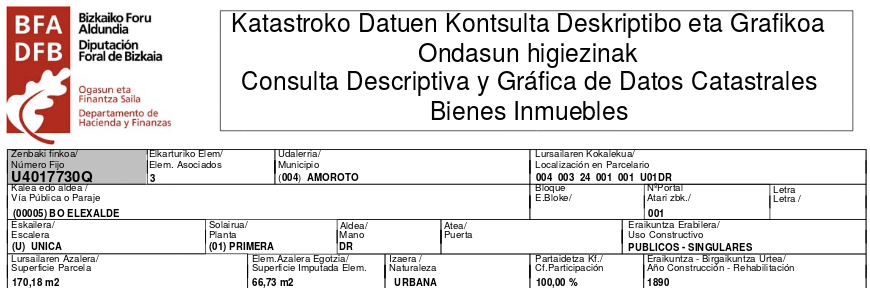

In [6]:
Image(filename='../images/cadastre_query.png') 

Here we get some information about the meaning of the fields in the CSV, as this PDF header is just a rendered version of it. 

First, the *Año_const* field does not only mean the date of construction, but it can reference the latest restoration date. This will partially impact the of the final map, as there is no way of getting the original construction year just with the publicly available data.

If we focus on the *Lursailaren Kokalekua* section (which, when translated into English roughly means *Plot localization*), we will see a set of six codes. The first five, whereas the sixth, references a subdivision inside a building (for example, an apartment in a block).

We'll check that the code is indeed the same in the previous Pandas dataframe:

In [7]:
df_municipality = df_sample[df_sample.Ref_Catastral=='U4017730Q']
df_municipality[['Ref_Catastral','Codmun', 'Codpol', 'Codman','Codpar','Nº Edif']]


,Ref_Catastral,Codmun,Codpol,Codman,Codpar,Nº Edif
922,U4017730Q,4,3,24,1,1


And voilá, we now know how unique buildings can be identified in the CSV file, even if they have a large number of subdivisions and cadastre references. A building will be uniquely defined by the tuple of the shown values.

#### 2.2 Shapefiles

[Shapefiles](https://en.wikipedia.org/wiki/Shapefile) are basically vectorized data-formats for geospatial data. In the case of the publicly available cadastral data, we have different shapefiles (streets, plots, door numbers...). But to build the *Houses of Biscay* map, we will just focus on the shapefiles that contain building data. Those shapefiles have the *KU_Edificios* string in their filename.

Lets see what fields these shapefiles have:

In [8]:
r_shp = shapefile.Reader('../004/004_KU_Edificios.shp')
r_shp.fields

[('DeletionFlag', 'C', 1, 0),
 ['AREA', 'N', 19, 8],
 ['PERIMETER', 'N', 19, 8],
 ['COD_OBJETO', 'C', 5, 0],
 ['CLASE', 'C', 2, 0],
 ['CODPROV', 'N', 10, 0],
 ['CODMUN', 'N', 10, 0],
 ['CODPOL', 'N', 10, 0],
 ['CODMAN', 'N', 10, 0],
 ['CODPAR', 'N', 10, 0],
 ['CODEDI', 'N', 10, 0],
 ['CODCALLE', 'C', 5, 0],
 ['NUMPORTAL', 'C', 9, 0],
 ['XCENTRO', 'N', 19, 8],
 ['YCENTRO', 'N', 19, 8],
 ['F_MODIFICA', 'D', 8, 0],
 ['F_BAJA', 'D', 8, 0],
 ['OBSERVA', 'C', 50, 0],
 ['F_CARGA', 'D', 8, 0],
 ['EXPEDIENTE', 'C', 11, 0],
 ['shape_area', 'F', 19, 11],
 ['shape_len', 'F', 19, 11]]

Good! Shapefiles also have the building identifiers embedded (CODMUN, CODPOL, CODMAN, CODPAR, CODEDI), so it is possible to merge both CSV and shapefile datasets to infer the construction date of a shapefile record.

### 3. Add construction year to shapefile

This section shows the process of adding the construction date found in the CSV to the equivalent building in the shapefile. It first loads the information from the CSV and the Shapefile, and for each building entry in the shapefile (with the 'ED' value in the CLASE field), it finds the corresponding building in the CSV and later adds it to the shapefile again.

In [9]:
BUILDING_SHAPEFILE_PATH = '../data/buildings/'
BUILDING_SHAPEFILE_STRING = '_KU_Edificios.dbf'

BOUNDARY_SHAPEFILE_PATH = '../data/boundaries/'

CADASTRAL_CSV_PATH = '../data/csv/'
CADASTRAL_CSV_STRING = '.F20161002.CSV' #Data is from October 2nd, 2016

SHAPEFILE_SAVE_PATH = '../data/ext_buildings/'

RESULT_SAVE_PATH = '../data/results/'

In [10]:
shapefiles = [f for f in os.listdir(BUILDING_SHAPEFILE_PATH) if os.path.isfile(os.path.join(BUILDING_SHAPEFILE_PATH, f))]

# Extract municipality code from the first three digits in the filename
municipality_codes = {filename[0:3] for filename in shapefiles}
print(municipality_codes)
                   

{'030', '070', '013', '019', '055', '902', '038', '057', '020', '006', '063', '048', '032', '001', '913', '045', '036', '011', '083', '095', '018', '005', '054', '067', '910', '058', '009', '901', '004', '066', '911', '053', '037', '043', '074', '044', '021', '039', '075', '050', '042', '915', '091', '069', '914', '017', '071', '905', '023', '012', '060', '085', '028', '079', '047', '026', '912', '086', '024', '008', '090', '003', '016', '061', '015', '092', '031', '062', '084', '051', '080', '072', '907', '007', '025', '082', '081', '027', '035', '064', '078', '052', '029', '046', '089', '002', '065', '097', '022', '093', '088', '034', '014', '903', '077', '056', '041', '068', '040', '059', '909', '010', '904', '087', '076', '073', '094', '033', '049', '908', '906'}


In [11]:
def load_building_data(municipality_code):
    """
    Loads relevant building data from a CSV file to a Pandas 
    dataframe.
    
    Args:
        municipality_code(str): Three digit municipality id.
    Returns:
        df: Pandas dataframe listing buildings in the municipality
            with their identifying features and construction date.
    """
    global counter_csv_total_buildings
    df = pd.read_csv(
        CADASTRAL_CSV_PATH+municipality_code+CADASTRAL_CSV_STRING,
        sep='\s*\";"\s*', 
        usecols=['Codmun',
                 'Codpol',
                 'Codman',
                 'Codpar',               
                 'Nº Edif', 
                 'Año_Const'
                ],
        encoding = 'latin1',
        header=1,
        engine='python')
    
    df = df.drop_duplicates() # Buildings with several dwellings will have several identical entries
    
    counter_csv_total_buildings = counter_csv_total_buildings+len(df.index)
    return df

In [12]:
def find_building_construction_year(shp_record, buildings_df):
    """
    Finds the corresponding construction year of a Shapefile record 
    in a dataframe of buildings.
    
    Args:
        shp_record (Shapefile record): Buildings shapefile.
        buildings_df (Pandas df): Dataframe with building construction
            data.
    Returns:
        const_year: The corresponding construction year of the shapefile
            record.            
    """
    global counter_year_normal
    global counter_year_zero
    global counter_shp_non_buildings
    
    if rec[3] != 'ED': # ED code is for buildings. There are also non-buildings in the shapefile
        counter_shp_non_buildings = counter_shp_non_buildings+1 
        return 0 # Zero years are later filtered in the map
    
    corresponding_building = buildings_df[
                            (buildings_df['Codmun']   == int(shp_record[5])) & 
                            (buildings_df['Codpol']   == int(shp_record[6])) & 
                            (buildings_df['Codman']   == int(shp_record[7])) & 
                            (buildings_df['Codpar']   == int(shp_record[8])) & 
                            (buildings_df['Nº Edif']  == int(shp_record[9])) 
                           ]

    if corresponding_building.empty: # No equivalent in dataframe
            const_year = 0
            counter_year_zero = counter_year_zero + 1 
    else:
        assert len(corresponding_building.index) == 1, "More than one corresponding buildings in CSV"
        const_year = int(corresponding_building['Año_Const'])
        counter_year_normal = counter_year_normal + 1
        
    return const_year

In [13]:
# Main loop to compute all buildings from Biscay.
# Takes a while to compute.

# Counters to show some statistics after computation
counter_year_normal = 0
counter_year_zero = 0 
counter_csv_total_buildings = 0
counter_shp_total_buildings = 0
counter_shp_non_buildings = 0

for municipality_code in tqdm(municipality_codes):
    
    buildings_df = load_building_data(municipality_code)
    
    r_shp = shapefile.Reader(BUILDING_SHAPEFILE_PATH+municipality_code+BUILDING_SHAPEFILE_STRING)
    counter_shp_total_buildings = counter_shp_total_buildings + r_shp.numRecords
    
    w_shp = shapefile.Writer()

    # Copy over the existing fields
    w_shp.fields = list(r_shp.fields)
    # Add construction year field 
    w_shp.field("ANO_CONST", "N", "40")
   
    for rec in r_shp.records():
        const_year = find_building_construction_year(rec,buildings_df)
        
        rec.append(const_year) # Append building year to record
        w_shp.records.append(rec) # Append extended record to Shapefile writer
                          

    # Copy the geometry of shapefiles and save them.
    w_shp._shapes.extend(r_shp.shapes())
    w_shp.save(SHAPEFILE_SAVE_PATH+municipality_code+'_EXT'+BUILDING_SHAPEFILE_STRING)
    
    

100%|██████████| 111/111 [04:56<00:00,  1.05it/s]


In [14]:
print('Total number of buildings in CSV files: {}'.format(counter_csv_total_buildings))
print('Total number of buildings in the shapefiles: {}'.format(counter_shp_total_buildings))
print('Buildings without the tag "ED" in the shapefiles: {}'.format(counter_shp_non_buildings))
print('Matched shapefile buildings: {}'.format(counter_year_normal))
print('Unmatched shapefile buildings: {}'.format(counter_year_zero))

Total number of buildings in CSV files: 143420
Total number of buildings in the shapefiles: 143550
Buildings without the tag "ED" in the shapefiles: 16539
Matched shapefile buildings: 126740
Unmatched shapefile buildings: 271


### 4. Merge municipality data

Now we have a set of shapefiles (one per municipality) with integrated construction data. To make things simpler when creating the map with Tilemill, we will merge these shapefiles into a single one.

In [15]:
def merge_shapefiles(shapefiles_paths, shapefile_type):
    """
    Merges a set of shapefiles into a larger single one.
    
    Args:
        shapefiles_paths (list): A list with the shapefiles to merge.
        shapefile_type (str): The type of shapefiles to indicate it in
            the final save.
    """
    shp_merger = shapefile.Writer()
    for shp in shapefiles_paths:
        r_shp = shapefile.Reader(shp)
        shp_merger._shapes.extend(r_shp.shapes())
        shp_merger.records.extend(r_shp.records())
    shp_merger.fields = list(r_shp.fields)
    shp_merger.save(RESULT_SAVE_PATH+shapefile_type)

In [16]:
building_shapefiles = glob.glob(SHAPEFILE_SAVE_PATH+'*.shp')
merge_shapefiles(building_shapefiles, "all_buildings")

Similarly, we will also merge the shapefiles of municipality boundaries to create a single municipality map of Biscay. These boundary shapefiles are included in the Zip files of the cadastre, so no preprocessing is needed to merge them.

In [17]:
municipality_shapefiles = glob.glob(BOUNDARY_SHAPEFILE_PATH+'*.shp')
merge_shapefiles(municipality_shapefiles, "all_boundaries")

Now we are ready to load the shapefiles into Tilemill and create the proper map.